In [1]:
import os

# Set the PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT environment variable to 0.6 seconds
# os.environ['PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT'] = '0.7'

import torch
import matplotlib.pyplot as plt
import networkx as nx
import collections

from copy import deepcopy

# local
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')



from datasets.import_dataset import import_dataset
from trainer import Trainer
from utils.plotting import *
from utils import utils
import datasets.simulations as sim
import link_prediction as lp





device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')


%load_ext autoreload
%autoreload 2

device = cuda


In [ ]:
# densification for link prediction: take a subgraph that is not
# link prediction: i know some of the nodes and a bunch is dyads on which i need to predict. so take a subgraph 
# so do a densification on all of the edges you have and omitted dyads are the same

#densification. need to do a special densification here. separate between 1 and 0 after the dyads were omitted. so the dyads omittion needs to happen before the densification which makes everything ugly. why does the dyads omittion happen when it does? i think that the m


# Test Run

In [1]:
# train = 85% val = 5% test = 10%
# need to omit 15% of the nodes, then run accuracy on the 5% validation set


photo_ds = import_dataset('photo')
photo_ds.edge_index.shape

dyads_to_omit = lp.get_dyads_to_omit(photo_ds.edge_index, 0.1)
photo_ds_omitted = lp.omit_densify_split(
                            photo_ds, 
                            dyads_to_omit,
                            val_rel_size=0.0,
                            densify=True)


# todo: make densification

#todo: refactor acctracke
#todo: anomaly detection before the algorithm. what to do with the anomalous nodes

config_triplets = [
    # ['feat_opt', 'lr', 0.000001],
    # ['prior_opt', 'lr', 0.000001],
    ['back_forth','n_back_forth', 5]
                   ]

trainer_photo_ieclam = Trainer(
                        dataset=photo_ds_omitted,
                        model_name='piegam',
                        task='link_prediction',
                        config_triplets_to_change=config_triplets,
                        attr_opt=False,
                        device=device,
)

# for link prediction we need to do the densification after omitting the dyads otherwise... otherwise we need to tell the omit dyads function... why not just do the omit dyads before trainer and have the dataset omitted. that will probably be the easiest and there will be no need for edge index original and all of that crap

losses, acc_test, acc_val = trainer_photo_ieclam.train(
            init_type='small_gaus',
            init_feats=True,
            acc_every=20,
            plot_every=-1,
            verbose=False,
            verbose_in_funcs=False
        )

del photo_ds, photo_ds_omitted
torch.cuda.empty_cache()


NameError: name 'import_dataset' is not defined

# Grid search params


/home/user/Documents/danny/AAAI_pieclam/experiments/../datasets/import_dataset.py:410: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)




/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:43 starting optimization of piegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 56,
        "dim_attr": 100,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-05,
        "n_iter": 10,
        "early_stop": 0
    },
    "prior_opt": {
        "n_iter": 12,
        "lr": 1e-05,
        "noise_amp": 0.1,
        "weight_decay": 0.1,
        "early_stop": 0
    },
    "back_forth": {
        "n_back_forth": 7,
        "scheduler_step_size": 3,
        "scheduler_gamma": 0.5,
        "early_stop_fit": 0,
        "first_func_in_fit": "fit_feats"
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:541:::  
in fit,
first_func_in_fit='fit_feats'
second_function_name='fit_prior'


/home/user/Documen

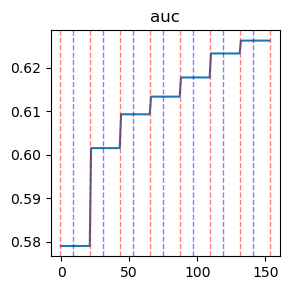



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:664:::  
fit end, no early stopping


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.6262764209305103


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:48 starting optimization of piegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 56,
        "dim_attr": 100,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-05,
        "n_iter": 10,
        "early_stop": 0
    },
    "prior_opt": {
        "n_iter": 12,
        "lr": 5e-06,
        "noise_amp": 0.1,
        "weight_decay": 0.1,
        "early_stop": 0
    },
    "back_forth": {
        "n_back_fo

UnboundLocalError: cannot access local variable 'accuracies_test' where it is not associated with a value

In [2]:
import os
import json
from utils import saving_utils

# todo: make a json for which the beginning is either the config to which we make the deltas and then there are results and the deltas. 
#todo: make a early stop for when the acc goes down and take the best last acc in fit function. the last alternation should be saved 
#todo: remove the scheduler

# train = 85% val = 5% test = 10%
# need to omit 15% of the nodes, then run accuracy on the 5% validation set
# LOOP TEST MANY HYPERS. COMMUNITIES, NOISE AMPS, ITERATIONS, LEARNING RATES

acc_configs = {}

iters_prior = [1300, 2000, 1000]
iters_feat = [500, 1000, 2000]
lrs_feat = [0.00001, 0.000005, 0.000001]
lrs_prior = [0.00001, 0.000005, 0.000001]
noise_amps = [0.1, 0.05, 0.01]



# Create the file if it doesn't exist

model_name = 'piegam'
ds_name = 'photo'
global_config_base = True



save_path = os.path.join(os.getcwd(), 'results', 'link_prediction', ds_name, model_name, 'acc_configs.json')
save_run = saving_utils.SaveRun(model_name, ds_name, global_config_base, save_path)
    # it's a new file

try:
    for noise_amp in noise_amps:
        for iter_prior in iters_prior:
            for iter_feat in iters_feat:
                for lr_feat in lrs_feat:
                    for lr_prior in lrs_prior:

                        photo_ds = import_dataset('photo')
                        photo_ds.edge_index.shape

                        dyads_to_omit = lp.get_dyads_to_omit(photo_ds.edge_index, 0.1)
                        photo_ds_omitted = lp.omit_densify_split(
                                                    photo_ds, 
                                                    dyads_to_omit,
                                                    val_rel_size=0.0,
                                                    densify=False)

                        #todo: we should use validation since every dataset should have differet configs. maybe just the communities l1 and s reg?

                        #todo: refactor acctrack
                        #todo: anomaly detection before the algorithm. what to do with the anomalous nodes
                        # todo: also add the hypers that you were able to go over

                        config_triplets = [
                            ['feat_opt', 'lr', lr_feat],
                            ['feat_opt', 'n_iter', 10],
                            ['prior_opt', 'lr', lr_prior],
                            ['prior_opt', 'noise_amp', noise_amp],
                            ['prior_opt', 'n_iter', 12],
                            ['back_forth','n_back_forth', 7],
                                        ]

                        trainer_photo_ieclam = Trainer(
                                                dataset=photo_ds_omitted,
                                                model_name='piegam',
                                                task='link_prediction',
                                                config_triplets_to_change=config_triplets,
                                                mighty_configs_dict=True,
                                                attr_opt=False,
                                                device=device,
                        )

                        # for link prediction we need to do the densification after omitting the dyads otherwise... otherwise we need to tell the omit dyads function... why not just do the omit dyads before trainer and have the dataset omitted. that will probably be the easiest and there will be no need for edge index original and all of that crap

                        losses, acc_test, acc_val = trainer_photo_ieclam.train(
                                    init_type='small_gaus',
                                    init_feats=True,
                                    acc_every=20,
                                    plot_every=-1,
                                    verbose=False,
                                    verbose_in_funcs=False
                                )
                        #todo: i need a way to print nothing. verbose should be a number between 0 and 2. verbose 2 is the verbose we have now. verbose 1 is the not verbose we have now. verbose 0 is print nothing nothing.
                        #todo: change iegam to ieclam everywhere.
                        
                        last_acc = acc_test['auc'][-1]

                        save_run.update_file(last_acc, config_triplets)
                        # Append the sorted_acc_configs to the existing file
                       
                        acc_configs[last_acc] = config_triplets

                        del photo_ds, photo_ds_omitted
                        torch.cuda.empty_cache()
except Exception as e:
    raise e




# VANILLA - Affiliation Space Dimension

In [ ]:
print(2)



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:53 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


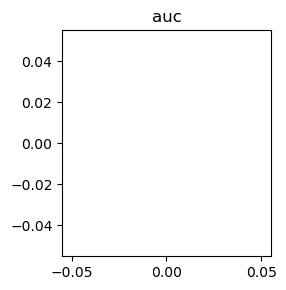



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5125787326579355


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:54 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


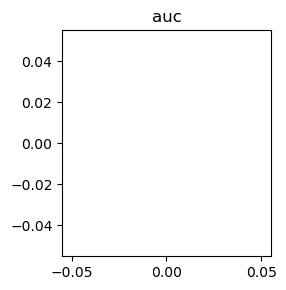



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5111849903036753


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:54 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


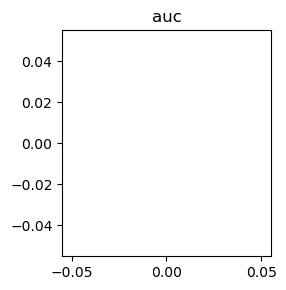



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.514761416984762


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:55 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


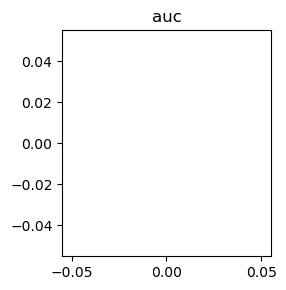



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5106831013859192


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:55 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


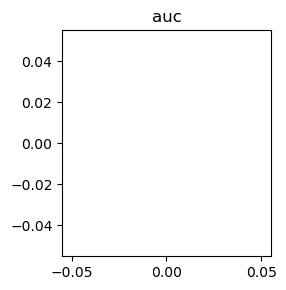



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.49895225255382586


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:56 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


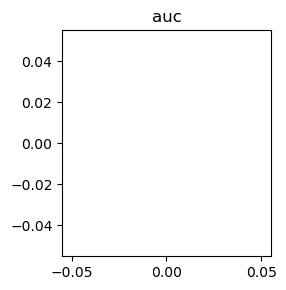



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5163952998967696


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:56 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


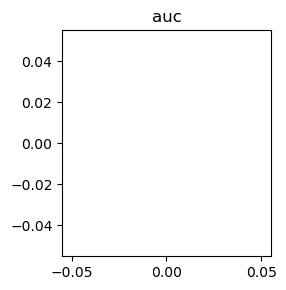



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5239789630145056


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:57 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


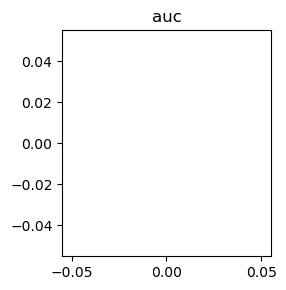



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5135260004994158


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:57 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


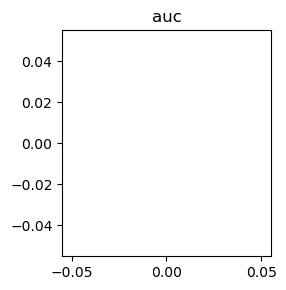



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5070257657317951


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:57 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


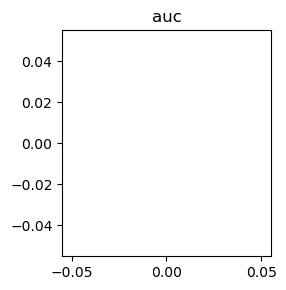



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.520901171717781


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:58 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


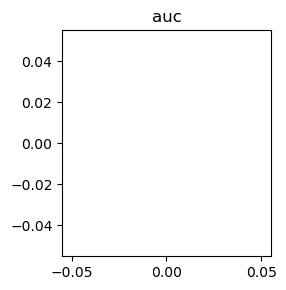



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5050597103761593


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:58 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.1,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


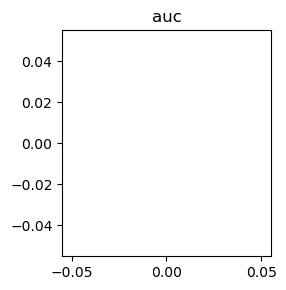



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5216303236394813


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:59 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.01,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


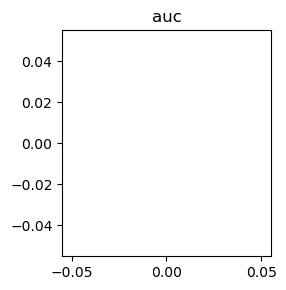



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5095518803201335


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:05:59 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.01,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


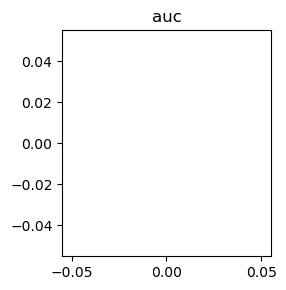



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5096360987217221


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:06:00 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.01,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


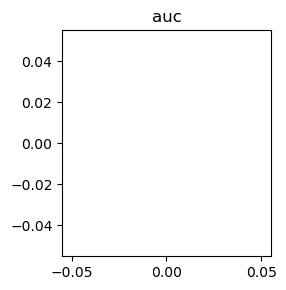



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5089841636591307


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:06:00 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.01,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


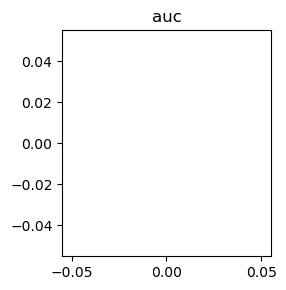



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5352485638166494


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:06:01 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.01,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


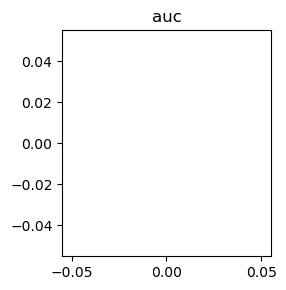



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5111217095643106


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:06:01 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 0.01,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


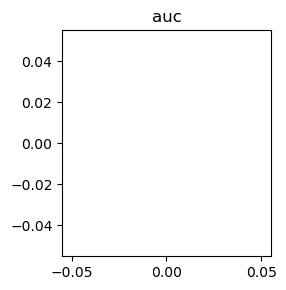



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5048937490717501


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:06:02 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 1,
        "l1_reg": 0.1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


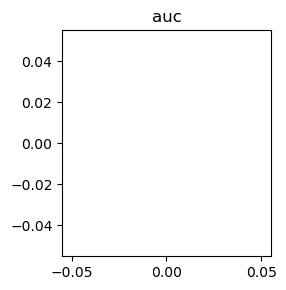



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5036261655159061


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:312:::  
 2024-09-22 00:06:02 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 36,
        "s_reg": 1,
        "l1_reg": 0.1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 10,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9


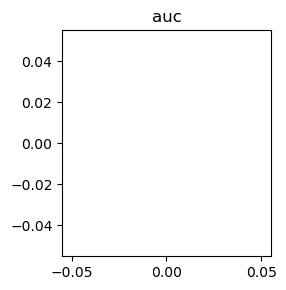



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  


FINISHED train 
 last accuracies:
auc: 0.5179408984585638


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:433:::  





KeyboardInterrupt: 

In [3]:
# VANILLA ARRS
dim_attrs = [50, 100, 150]

dim_feats = [36, 40, 46, 50, 56, 60, 66, 70, 76, 80]
noise_amps = [0.1, 0.05, 0.01]
iters_prior = [1300, 2000, 1000]
iters_feat = [500, 1000, 2000]
lrs_feat = [0.00005, 0.000001, 0.000001]
lrs_prior = [0.00005, 0.000001, 0.000001]
l1_regs = [1, 0.1, 0.01]
s_regs = [1, 0.1, 0.01]

acc_dict = {model_name: {dim_feat: {l1_reg: [] for l1_reg in l1_regs} for dim_feat in dim_feats} for model_name in ['bigclam', 'iegam']}

model_name = 'iegam'
ds_name = 'photo'
global_config_base = False
save_path = os.path.join(os.getcwd(), 'results', 'link_prediction', ds_name, model_name, 'acc_configs.json')

save_run = saving_utils.SaveRun(model_name, ds_name, global_config_base, save_path)

#todo: how to run with val set properly?

for model_name in ['iegam', 'bigclam']:
    for dim_feat in dim_feats:
        for l1_reg in l1_regs:
            for s_reg in s_regs:
                for _ in range(6):    
                    photo_ds = import_dataset('photo')
                    photo_ds.edge_index.shape

                    dyads_to_omit = lp.get_dyads_to_omit(photo_ds.edge_index, 0.1)
                    photo_ds_omitted = lp.omit_densify_split(
                                                photo_ds, 
                                                dyads_to_omit,
                                                val_rel_size=0.0,
                                                densify=False)


                    # todo: make densification

                    #todo: refactor acctracke
                    #todo: anomaly detection before the algorithm. what to do with the anomalous nodes

                    config_triplets = [
                        ['clamiter_init', 'dim_feat', dim_feat],
                        ['clamiter_init', 'l1_reg', l1_reg],
                        ['clamiter_init', 's_reg', s_reg],
                        ['feat_opt', 'n_iter', 10]
                                    ]

                    trainer_photo_ieclam = Trainer(
                                            dataset=photo_ds_omitted,
                                            model_name=model_name,
                                            task='link_prediction',
                                            config_triplets_to_change=config_triplets,
                                            mighty_configs_dict=False,
                                            attr_opt=False,
                                            device=device,
                    )

                    # for link prediction we need to do the densification after omitting the dyads otherwise... otherwise we need to tell the omit dyads function... why not just do the omit dyads before trainer and have the dataset omitted. that will probably be the easiest and there will be no need for edge index original and all of that crap

                    losses, acc_test, acc_val = trainer_photo_ieclam.train(
                                init_type='small_gaus',
                                init_feats=True,
                                acc_every=20,
                                plot_every=-1,
                                verbose=False,
                                verbose_in_funcs=False
                            )
                    
                    save_run.update_file(acc_test['auc'][-1], config_triplets)
                    # acc_dict[model_name][dim_feat][l1_reg].append(acc_test['auc'][-1])
                    del photo_ds, photo_ds_omitted
                    del trainer_photo_ieclam.data
                    torch.cuda.empty_cache()

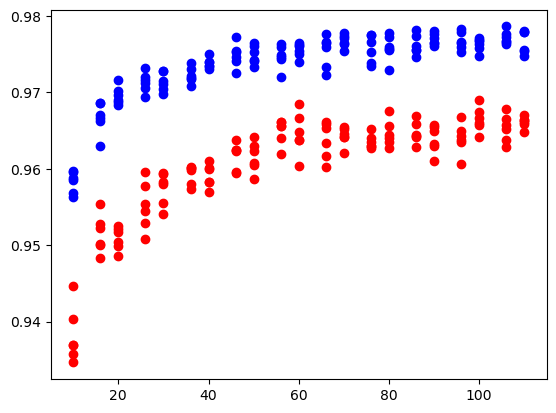

In [26]:
import matplotlib.pyplot as plt

# Extract the data for bigclam and iegam
bigclam_data = acc_dict['bigclam']
iegam_data = acc_dict['iegam']

# Plot the data
for key in bigclam_data.keys():
    for data in bigclam_data[key]:
        plt.plot(key,data,'o', color='blue', label='bigclam', linestyle='none')
for key in iegam_data.keys():
    for data in iegam_data[key]:
        plt.plot(key,data, 'o', color='red', label='iegam', linestyle='none')

# ithink maybe 40 for big and 80 for ie
    
    

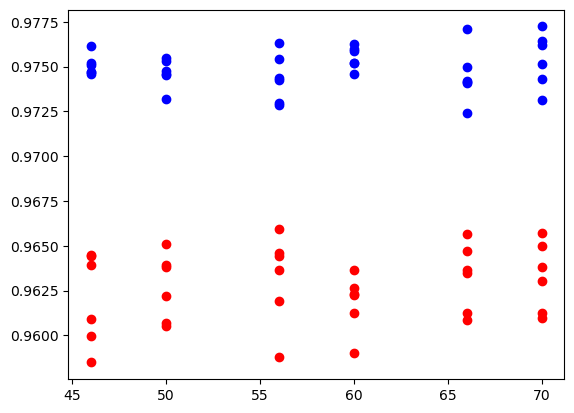

In [38]:
acc_dict
import matplotlib.pyplot as plt

# Extract the data for bigclam and iegam
bigclam_data = acc_dict['bigclam']
iegam_data = acc_dict['iegam']

# Plot the data
for key in bigclam_data.keys():
    plt.plot(dim_feats, bigclam_data[key], 'o', color='blue', label='bigclam', linestyle='none')
    plt.plot(dim_feats, iegam_data[key], 'o', color='red', label='iegam', linestyle='none')
    

# plt.plot(dim_feats, bigclam_data, color='blue', label='bigclam')
# plt.plot(dim_feats, iegam_data, color='red', label='iegam')

# # Add labels and title
# plt.xlabel('Dim Feat')
# plt.ylabel('AUC')
# plt.title('AUC vs Dim Feat')

# # Add legend
# plt.legend()

# # Show the plot
# plt.show()

In [25]:
acc_dict

{'bigclam': {36: [0.9727175209227668, 0.9723776342604988],
  40: [0.972267407076946, 0.9718492448404841],
  50: [0.9763531931124269, 0.9762211485460616]},
 'iegam': {36: [0.9655798708689162, 0.9567564327892888],
  40: [0.9570085710707769, 0.9578119610378143],
  50: [0.9598908052110603, 0.9617079782205947]}}

In [ ]:
#   'bigclam': {
#   10: [0.9585404724760899, 0.9639035086504821],
#   20: [0.9684866796298274, 0.9682561623880347],
#   30: [0.9715515773390894, 0.9679066481381807],
#   40: [0.973401410354128, 0.975028281881877]},
#  'iegam': {
#   10: [0.9363348119751429, 0.9362004879243281],
#   20: [0.953740656284433, 0.9519222289221715],
#   30: [0.9568455111402209, 0.9550952164216329],
#   40: [0.9605243983039492, 0.9610890825556342]}}